## EGG_Mini Project
Detection of abnormalities of gastric function via electrogastrography (EGG) analysis
recorded by the smart belt

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import os

### Data loading

In [ ]:
nb_patients = 7

normal_before = []
normal_after = []
pd_before = []
pd_after = []

base_path = "/content/drive/MyDrive/AIMove/Healthcare and IOT" # specify working directory

for i in range (1,8):
    
    path_nafter = os.path.join(base_path, 'EGG_data', 'n{}after.csv'.format(i))
    path_nbefore = os.path.join(base_path, 'EGG_data', 'n{}before.csv'.format(i))
    path_pdafter = os.path.join(base_path, 'EGG_data', 'pd{}after.csv'.format(i))
    path_pdbefore = os.path.join(base_path, 'EGG_data', 'pd{}before.csv'.format(i))
    
    normal_before.append(np.array(pd.read_csv('{}'.format(path_nbefore))).T[0])
    normal_after.append(np.array(pd.read_csv('{}'.format(path_nafter))).T[0])
    pd_before.append(np.array(pd.read_csv('{}'.format(path_pdbefore))).T[0])
    pd_after.append(np.array(pd.read_csv('{}'.format(path_pdafter))).T[0])
    
    
normal_before_raw = np.array(normal_before)   # Array that contain the 7 series of Healthy Patient before eating
normal_after_raw = np.array(normal_after)     # Array that contain the 7 series of Healthy Patient after eating
pd_before_raw = np.array(pd_before) # Array that contain the 7 series of Patient with parkinson before eating
pd_after_raw = np.array(pd_after)   # Array that contain the 7 series of Patient with parkinson after eating

print("normal_before_raw.shape : ",normal_before_raw.shape)
print("normal_after_raw.shape : ",normal_after_raw.shape)
print("pd_before_raw.shape : ",pd_before_raw.shape)
print("pd_after_raw.shape : ",pd_after_raw.shape)

normal_before_raw.shape :  (7, 1799999)
normal_after_raw.shape :  (7, 1799999)
pd_before_raw.shape :  (7, 1799999)
pd_after_raw.shape :  (7, 1799999)


#### Display Data

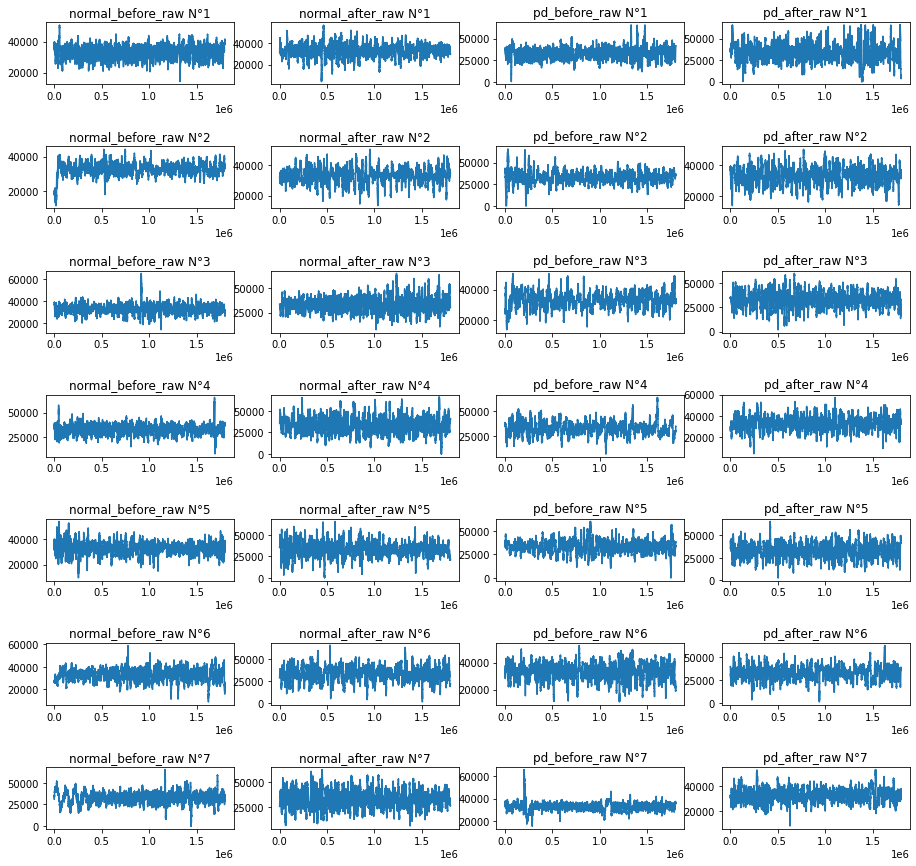

In [ ]:
fig, axes = plt.subplots(7, 4)
for i in range(nb_patients):
    axes[i,0].plot(normal_before_raw[i])
    axes[i,0].set_title("normal_before_raw N°" + str(i+1), fontsize=12)
    axes[i,1].plot(normal_after_raw[i])
    axes[i,1].set_title("normal_after_raw N°" + str(i+1), fontsize=12)
    axes[i,2].plot(pd_before_raw[i])
    axes[i,2].set_title("pd_before_raw N°" + str(i+1), fontsize=12)
    axes[i,3].plot(pd_after_raw[i])
    axes[i,3].set_title("pd_after_raw N°" + str(i+1), fontsize=12)
    
plt.subplots_adjust(left=0., right=2, top=3, bottom=0.2,hspace = 1)

### Preprocessing

In [ ]:
#I/Normalise the signals from [0, 65535] range to [-1, +1] range.
normal_before  = normal_before_raw*2/65535 -1
normal_after   = normal_after_raw*2/65535 -1
pd_before = pd_before_raw*2/65535 -1
pd_after  = pd_after_raw*2/65535 -1
    
#II/for each signal, subtract its mean value.

normal_before  = normal_before - np.mean(normal_before)
normal_after   = normal_after - np.mean(normal_after)
pd_before = pd_before - np.mean(pd_before)
pd_after  = pd_after - np.mean(pd_after)

#III/Apply low-pass filter with cut-off frequency at 1.5 Hz.

sos = signal.butter(3, 1.5, 'low', fs=1000, output='sos')
for i in range(nb_patients):
    normal_before[i] = signal.sosfilt(sos, normal_before[i])
    normal_after[i] = signal.sosfilt(sos, normal_after[i])
    pd_before[i] = signal.sosfilt(sos, pd_before[i])
    pd_after[i] = signal.sosfilt(sos, pd_after[i])

### Feature Extraction

In [ ]:
## Create windows

# Size of the sliding window = 4 min 
points_per_window = 240000 # 4 min * 60 s/min * 1000 1/s = 240000 is the number of points to take per window
points_per_step = 60000 # 1 min * 60 s/min * 1000 1/s = 60000 is the step
nb_windows = 26 # Number of windows per sequence
M = np.hamming(points_per_window) # hamming window to multiply

# creating dictionaries to host data windows
continuous_data={'normal_before': normal_before, 
      'normal_after': normal_after, 
      'pd_before': pd_before, 
      'pd_after': pd_after}
      
windowed_data = {'normal_before': np.zeros((nb_patients, nb_windows, points_per_window)), 
                 'normal_after': np.zeros((nb_patients, nb_windows, points_per_window)), 
                 'pd_before': np.zeros((nb_patients, nb_windows, points_per_window)), 
                 'pd_after': np.zeros((nb_patients, nb_windows, points_per_window))}

# for each category
for category_index in windowed_data:
  # for each patient in each category
  for patient_counter in range(len(windowed_data[category_index])):
    # for each window for each patient data
    for window_counter in range(nb_windows):
      t_0 = window_counter * points_per_step  # Time at which window begins
      t_f = t_0 + points_per_window           # Time at which window ends
      # the current window is filled with the points found at the right index from the original data
      windowed_data[category_index][patient_counter][window_counter] = continuous_data[category_index][patient_counter][t_0:t_f] * M

### 1. Mean and standard deviation of dominant frequency (in cycles per minute) and dominant power. 
Dominant frequency is the frequency that corresponds to the
maximum power of the signal (dominant power).

In [ ]:
nb_categories = len(windowed_data)

####### CATEGORY INDEXING ######
# Inside features dictionary, for fourier, dp, and df, first axis: 
# 0 => normal_before
# 1 => normal_after
# 2 => pd_before
# 3 => pd_after

# dictionary containing features, one per window
features = {'fourier_analysis': np.zeros((nb_categories, nb_patients, nb_windows, points_per_window)),
            'dominant_power': np.zeros((nb_categories, nb_patients, nb_windows)),
            'dominant_frequency': np.zeros((nb_categories, nb_patients, nb_windows))}

# Getting dominant frequencies and dominant powers for all the windows
freq = np.fft.fftfreq(n = points_per_window, d = 1/1000)

# for each category
for category_counter, category_index in enumerate(windowed_data):
  # for each patient in each category
  for patient_counter in range(nb_patients):
    # for each window for each patient data
    for window_counter in range(nb_windows):

      # I use variables to declutter the code a bit
      curr_window = windowed_data[category_index][patient_counter][window_counter]
      curr_fourier = features['fourier_analysis'][category_counter][patient_counter][window_counter] = np.abs(np.fft.fft(curr_window)/len(curr_window))

      features['dominant_power'][category_counter][patient_counter][window_counter] = curr_fourier[np.argmax(curr_fourier[:120000])]
      features['dominant_frequency'][category_counter][patient_counter][window_counter] = freq[np.argmax(curr_fourier[:120000])]*60

### 2. Ratio of dominant power after/before meal. 
The mean dominant power calculated above can be used for the calculation of the ratio.

In [ ]:
####### CATEGORY INDEXING ######
# Inside features dictionary, for fourier, dp, and df, first axis: 
# 0 => normal_before
# 1 => normal_after
# 2 => pd_before
# 3 => pd_after
#
# For ratio_dominant_power :
# 0 => normal
# 1 => pd

ratio_dp = np.zeros((2, nb_patients))

# for normal and pd patients: 
for category_counter in range(len(ratio_dp)):
  # for each patient in each category
  for patient_counter in range(nb_patients):
    # Here we divide the dominant power after lunch by the dominant power before lunch, for normal and then pd patients
    # so as categories in the dominant power features, we want 1/0 and 3/2
    # quick maths on category counter: the first sum gives 1 then 3 and the second 0 then 2 from the category_counter which will take the values 0 then 1
    ratio_dp[category_counter][patient_counter] = ( features['dominant_power'][(category_counter*2)+1][patient_counter].mean() / 
                                                    features['dominant_power'][category_counter*2][patient_counter].mean() )

features['ratio_dominant_power'] = ratio_dp

print("Ratio for Healthy Patient :\n", np.round(features['ratio_dominant_power'][0], 2))
print("Ratio for Parkinson Patient :\n", np.round(features['ratio_dominant_power'][1],2))

Ratio for Healthy Patient :
 [1.78 1.47 2.64 3.06 1.8  2.03 1.63]
Ratio for Parkinson Patient :
 [1.34 0.65 2.08 1.05 1.38 1.12 1.43]


### 3. Percentage of normogastria, bradygastria, tachygastria and other
The percentage is calculated as the number of windows that exhibit the specific behaviour (normogastria, bradygastria and tachygastria) to the total number of windows.

In [ ]:
####### CATEGORY INDEXING ######
# Inside features dictionary, for fourier, dp, and df, first axis: 
# 0 => normal_before
# 1 => normal_after
# 2 => pd_before
# 3 => pd_after
#
# For ratio_dominant_power :
# 0 => normal
# 1 => pd

# 4 is the number of behaviors
gastric_behavior_prct = np.zeros((nb_categories, nb_patients, 4))

for category_counter in range(nb_categories):
  for patient_counter in range(nb_patients):
    for window_counter in range(nb_windows):
      # patient has Normogastria
      if 2 <= features['dominant_frequency'][category_counter][patient_counter][window_counter] < 4:
        gastric_behavior_prct[category_counter][patient_counter][0] += 1
      # patient has Bradygastria
      if 0.5 <= features['dominant_frequency'][category_counter][patient_counter][window_counter] < 2:
        gastric_behavior_prct[category_counter][patient_counter][1] += 1
      # patient has Tachygastria
      if 4 <= features['dominant_frequency'][category_counter][patient_counter][window_counter] < 9:
        gastric_behavior_prct[category_counter][patient_counter][2] += 1
      # patient has other behavior
      if (features['dominant_frequency'][category_counter][patient_counter][window_counter] < 0.5 or 
          9 <= features['dominant_frequency'][category_counter][patient_counter][window_counter] <= 15 ):
        gastric_behavior_prct[category_counter][patient_counter][3] += 1

for category_counter in range(nb_categories):
  for patient_counter in range(nb_patients):
    gastric_behavior_prct[category_counter][patient_counter] /= nb_windows
    print(np.round(gastric_behavior_prct[category_counter][patient_counter],2))

features['gastric_behavior_%'] = gastric_behavior_prct

[0.92 0.04 0.04 0.  ]
[0.65 0.27 0.   0.08]
[0.92 0.08 0.   0.  ]
[0.5  0.42 0.   0.04]
[1. 0. 0. 0.]
[0.42 0.58 0.   0.  ]
[0.65 0.35 0.   0.  ]
[0.88 0.12 0.   0.  ]
[0.5 0.5 0.  0. ]
[1. 0. 0. 0.]
[0.96 0.04 0.   0.  ]
[0.85 0.15 0.   0.  ]
[0.88 0.12 0.   0.  ]
[1. 0. 0. 0.]
[1. 0. 0. 0.]
[0.88 0.12 0.   0.  ]
[0.19 0.81 0.   0.  ]
[0.23 0.73 0.   0.04]
[0.62 0.38 0.   0.  ]
[0.77 0.19 0.04 0.  ]
[0.62 0.35 0.   0.04]
[1. 0. 0. 0.]
[0.42 0.38 0.19 0.  ]
[0.88 0.12 0.   0.  ]
[0.46 0.42 0.12 0.  ]
[0.96 0.04 0.   0.  ]
[0.81 0.15 0.04 0.  ]
[0.73 0.23 0.04 0.  ]


### 4. Mean and standard deviation of the following ratios 
i) power of range [0.5, 2.0] / total power of range [0.5, 15.0], ii) power of range [2.0, 4.0] / total power of range [0.5, 15.0], iii) power of range [4.0, 9.0] / total power of range [0.5, 15.0] and iv) power of range [9.0, 15.0] / total power of range [0.5, 15.0]

In [ ]:
####### CATEGORY INDEXING ######
# Inside features dictionary, for fourier, dp, df, and power ratios first axis: 
# 0 => normal_before
# 1 => normal_after
# 2 => pd_before
# 3 => pd_after
#
# For ratio_dominant_power :
# 0 => normal
# 1 => pd

# 4 ratios by patient
mean_power_ratios = np.zeros((nb_categories, nb_patients, 4))
std_power_ratios = np.zeros((nb_categories, nb_patients, 4))

power = np.zeros((5))
power_ratios = np.zeros((nb_windows,4))

def return_power(curr_fourier, f_min, f_max):
  power = np.where(freq*60 >=f_min,curr_fourier,0)
  power = np.where(freq*60 <f_max,power,0)
  power = np.sum(power) 

  return power


for category_counter, category_index in enumerate(windowed_data):
  for patient_counter in range(nb_patients):
    for window_counter in range(nb_windows):
      curr_fourier = np.abs(np.fft.fft(windowed_data[category_index][patient_counter][window_counter] /
                                       windowed_data[category_index][patient_counter][window_counter].shape[0]))
      
      list_freq_min = [0.5, 0.5, 2, 4, 9]
      list_freq_max = [15, 2, 4, 9, 15]
      
      for i in range(5):
        power[i] = return_power(curr_fourier, list_freq_min[i], list_freq_max[i])
      
      for i in range(4):
        power_ratios[window_counter][i] = power[i+1] / power[0]
      
    for i in range(4):
      mean_power_ratios[category_counter][patient_counter][i] = np.mean(power_ratios[:, i], axis=0)
      std_power_ratios[category_counter][patient_counter][i] = np.std(power_ratios[:, i], axis=0)

features['mean_power_ratios'] = mean_power_ratios
features['std_power_ratios'] = std_power_ratios    

### 5. Overall dominant frequency and dominant power


In [ ]:
####### CATEGORY INDEXING ######
# Inside features dictionary, for fourier, dp, df, power ratios, and power over the entire signal first axis: 
# 0 => normal_before
# 1 => normal_after
# 2 => pd_before
# 3 => pd_after
#
# For ratio_dominant_power :
# 0 => normal
# 1 => pd

nb_sample = len(continuous_data['normal_before'][0])
M = np.hamming(nb_sample)
freq = np.fft.fftfreq(n = nb_sample, d = 1/1000)

entire_signal_power = np.zeros((nb_categories, nb_patients))
entire_signal_frequency = np.zeros((nb_categories, nb_patients))

for category_counter, category_index in enumerate(continuous_data):
  for patient_counter in range(nb_patients):

    curr_fourier = np.abs(np.fft.fft(continuous_data[category_index][patient_counter] * M)/nb_sample)

    entire_signal_power[category_counter][patient_counter] = curr_fourier[np.argmax(curr_fourier[:900000])]
    entire_signal_frequency[category_counter][patient_counter] = freq[np.argmax(curr_fourier[:900000])]*60

features['entire_signal_power'] = entire_signal_power
features['entire_signal_frequency'] = entire_signal_frequency

In [ ]:
print('General info:\n')
print('4: nb_categories (in respective order: normal_before, normal_after, pd_before, pd_after)')
print('7: nb_patients')
print('26: nb_windows')
print('60000: points_per_step')
print('240000: points_per_window')
print('----------------------------------------')
print('continuous_data contents:\n')
for category_index in continuous_data:
  print(f'{category_index}: {continuous_data[category_index].shape}')
print('----------------------------------------')
print('windowed_data contents:\n')
for category_index in windowed_data:
  print(f'{category_index}: {windowed_data[category_index].shape}')
print('----------------------------------------')
print('features contents:\n')
for feature_index in features:
  if feature_index == 'ratio_dominant_power':
    print(f'{feature_index}: {features[feature_index].shape} (axis 0: 0 = normal, 1 = pd)')
  elif feature_index == 'gastric_behavior_%':
    print(f'{feature_index}: {features[feature_index].shape} (axis 2: normogastria, tradygastria, tachygastria, other)')
  else:
    print(f'{feature_index}: {features[feature_index].shape}')

General info:

4: nb_categories (in respective order: normal_before, normal_after, pd_before, pd_after)
7: nb_patients
26: nb_windows
60000: points_per_step
240000: points_per_window
----------------------------------------
continuous_data contents:

normal_before: (7, 1799999)
normal_after: (7, 1799999)
pd_before: (7, 1799999)
pd_after: (7, 1799999)
----------------------------------------
windowed_data contents:

normal_before: (7, 26, 240000)
normal_after: (7, 26, 240000)
pd_before: (7, 26, 240000)
pd_after: (7, 26, 240000)
----------------------------------------
features contents:

fourier_analysis: (4, 7, 26, 240000)
dominant_power: (4, 7, 26)
dominant_frequency: (4, 7, 26)
ratio_dominant_power: (2, 7) (axis 0: 0 = normal, 1 = pd)
gastric_behavior_%: (4, 7, 4) (axis 2: normogastria, tradygastria, tachygastria, other)
mean_power_ratios: (4, 7, 4)
std_power_ratios: (4, 7, 4)
entire_signal_power: (4, 7)
entire_signal_frequency: (4, 7)


Text(0.5, 1.0, 'Dominant power by window for each category')

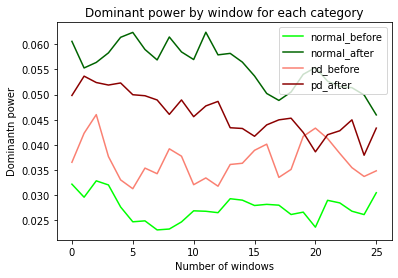

In [ ]:
mean_dp_by_category = np.mean(features['dominant_power'], axis=1)
categories = ['normal_before', 'normal_after', 'pd_before', 'pd_after']
colors = ['lime', 'darkgreen', 'salmon', 'darkred']

for i in range(4):
  plt.plot(mean_dp_by_category[i], label=categories[i], color=colors[i])

plt.legend()
plt.xlabel('Window') 
plt.ylabel('Dominant power') 
plt.title('Dominant power by window for each category') 

Text(0.5, 1.0, 'Repartition of dominant frequenncies for each category')

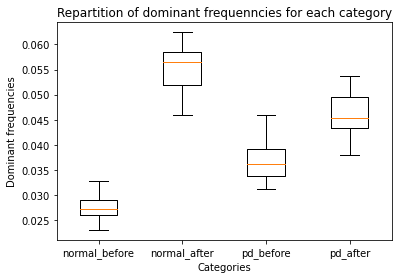

In [ ]:
plt.boxplot(mean_dp_by_category.T)

plt.xticks([1, 2, 3, 4], ['normal_before', 'normal_after', 'pd_before', 'pd_after'])

plt.xlabel('Categories') 
plt.ylabel('Dominant frequencies') 
plt.title('Repartition of dominant frequencies for each category') 

Text(0.5, 1.0, 'Repartition of dominant frequenncies for each category')

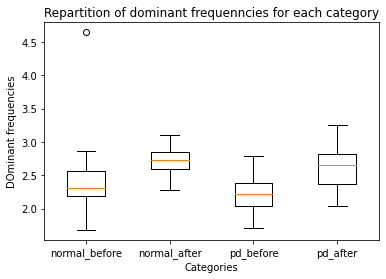

In [ ]:
# For the frequencies, the curves do not give much info so we only use boxplots
mean_df_by_category = np.mean(features['dominant_frequency'], axis=1)

plt.boxplot(mean_df_by_category.T)

plt.xticks([1, 2, 3, 4], ['normal_before', 'normal_after', 'pd_before', 'pd_after'])

plt.xlabel('Categories') 
plt.ylabel('Dominant frequencies') 
plt.title('Dominant frequencies distribution by category') 

Text(0.5, 1.0, 'Power ratio distribution by category')

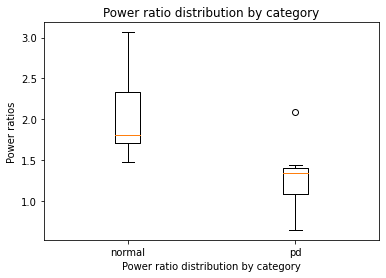

In [49]:
power_ratios_by_category = features['ratio_dominant_power']

plt.boxplot(power_ratios_by_category.T)

plt.xticks([1, 2], ['normal', 'pd'])

plt.xlabel('Power ratio distribution by category') 
plt.ylabel('Power ratios')
plt.title('Power ratio distribution by category') 

Text(0.5, 1.0, 'Entire signal power distribution by category')

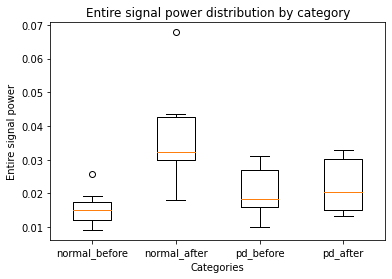

In [50]:
entire_signal_power = features['entire_signal_power']

plt.boxplot(entire_signal_power.T)

plt.xticks([1, 2, 3, 4], ['normal_before', 'normal_after', 'pd_before', 'pd_after'])

plt.xlabel('Categories') 
plt.ylabel('Entire signal power') 
plt.title('Entire signal power distribution by category') 

[2.90000161 3.23333513 3.16666843 3.16666843 2.86666826 3.13333507
 3.13333507]
[3.06666837 3.36666854 1.00000056 0.93333385 1.800001   3.00000167
 2.43333469]


Text(0.5, 1.0, 'Entire signal frequency distribution by category')

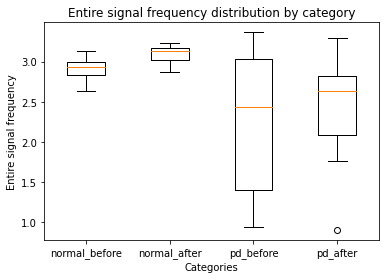

In [53]:
entire_signal_frequency = features['entire_signal_frequency']

plt.boxplot(entire_signal_frequency.T)

plt.xticks([1, 2, 3, 4], ['normal_before', 'normal_after', 'pd_before', 'pd_after'])

plt.xlabel('Categories') 
plt.ylabel('Entire signal frequency') 
plt.title('Entire signal frequency distribution by category') 

### Features preparation for ML algorithms

In [ ]:
i=0
data2 = pd.DataFrame(columns =['mean_freq_cycle_before','Std_freq_cycle_before','mean_freq_cycle_after',
                               'Std_freq_cycle_after','mean_power_cycle_before','Std_power_cycle_before',
                               'mean_power_cycle_after','Std_power_cycle_after','ratio_after/before',
                               'percentage_normogastria_before','percentage_bradygastria_before', 
                               'percentage_tachygastria_before','percentage_other_before' ,
                               'percentage_normogastria_After','percentage_bradygastria_After' , 
                               'percentage_tachygastria_After' , 'percentage_other_After',
                               'mean_power_1_before','mean_power_2_before','mean_power_3_before','mean_power_4_before',
                               'mean_power_1_after','mean_power_2_after','mean_power_3_after','mean_power_4_after',
                               'std_power_1_before','std_power_2_before','std_power_3_before','std_power_4_before',
                               'std_power_1_after','std_power_2_after','std_power_3_after','std_power_4_after',
                               'entire_signal_power_before' , 'entire_signal_power_after',
                               'entire_signal_freq_before','entire_signal_freq_after',
                               'class'])
# data1.set_index('sequence', inplace = True)
for j in range(nb_patients):
    
    Features_healthy_patients= {
               'mean_freq_cycle_before':features['dominant_frequency'][0][j].mean(),
               'Std_freq_cycle_before':features['dominant_frequency'][0][j].std(),
               'mean_freq_cycle_after':features['dominant_frequency'][1][j].mean(),
               'Std_freq_cycle_after':features['dominant_frequency'][1][j].std(),             
               'mean_power_cycle_before':features['dominant_power'][0][j].mean(),
               'Std_power_cycle_before':features['dominant_power'][0][j].std(),
               'mean_power_cycle_after':features['dominant_power'][1][j].mean(),
               'Std_power_cycle_after':features['dominant_power'][1][j].std(), 
               'ratio_after/before':features['ratio_dominant_power'][0][j],
               'percentage_normogastria_before':features['gastric_behavior_%'][0][j][0],
               'percentage_bradygastria_before':features['gastric_behavior_%'][0][j][1],
               'percentage_tachygastria_before':features['gastric_behavior_%'][0][j][2],
               'percentage_other_before':features['gastric_behavior_%'][0][j][3],
               'percentage_normogastria_After':features['gastric_behavior_%'][1][j][0],
               'percentage_bradygastria_After':features['gastric_behavior_%'][1][j][1],
               'percentage_tachygastria_After':features['gastric_behavior_%'][1][j][2],
               'percentage_other_After':features['gastric_behavior_%'][1][j][3],
               'mean_power_1_before':features['mean_power_ratios'][0][j][0],
               'mean_power_2_before':features['mean_power_ratios'][0][j][1],
               'mean_power_3_before':features['mean_power_ratios'][0][j][2],
               'mean_power_4_before':features['mean_power_ratios'][0][j][3],
               'mean_power_1_after':features['mean_power_ratios'][1][j][0],
               'mean_power_2_after':features['mean_power_ratios'][1][j][1],
               'mean_power_3_after':features['mean_power_ratios'][1][j][2],
               'mean_power_4_after':features['mean_power_ratios'][1][j][3],
               'std_power_1_before':features['std_power_ratios'][0][j][0],
               'std_power_2_before':features['std_power_ratios'][0][j][1],
               'std_power_3_before':features['std_power_ratios'][0][j][2],
               'std_power_4_before':features['std_power_ratios'][0][j][3],
               'std_power_1_after':features['std_power_ratios'][1][j][0],
               'std_power_2_after':features['std_power_ratios'][1][j][1],
               'std_power_3_after':features['std_power_ratios'][1][j][2],
               'std_power_4_after':features['std_power_ratios'][1][j][3],
               'entire_signal_power_before':features['entire_signal_power'][0][j],
               'entire_signal_power_after':features['entire_signal_power'][1][j],
               'entire_signal_freq_before':features['entire_signal_frequency'][0][j],
               'entire_signal_freq_after':features['entire_signal_frequency'][1][j],
               'class':0}
    i+=1
    data2.loc[i]=Features_healthy_patients
    Features_pd_patients= {
               'mean_freq_cycle_before':features['dominant_frequency'][2][j].mean(),
               'Std_freq_cycle_before':features['dominant_frequency'][2][j].std(),
               'mean_freq_cycle_after':features['dominant_frequency'][3][j].mean(),
               'Std_freq_cycle_after':features['dominant_frequency'][3][j].std(),
                'mean_power_cycle_before':features['dominant_power'][2][j].mean(),
               'Std_power_cycle_before':features['dominant_power'][2][j].std(),
               'mean_power_cycle_after':features['dominant_power'][3][j].mean(),
               'Std_power_cycle_after':features['dominant_power'][3][j].std(), 
                'ratio_after/before':features['ratio_dominant_power'][1][j],
               'percentage_normogastria_before':features['gastric_behavior_%'][2][j][0],
               'percentage_bradygastria_before':features['gastric_behavior_%'][2][j][1],
               'percentage_tachygastria_before':features['gastric_behavior_%'][2][j][2],
               'percentage_other_before':features['gastric_behavior_%'][2][j][3],
               'percentage_normogastria_After':features['gastric_behavior_%'][3][j][0],
               'percentage_bradygastria_After':features['gastric_behavior_%'][3][j][1],
               'percentage_tachygastria_After':features['gastric_behavior_%'][3][j][2],
               'percentage_other_After':features['gastric_behavior_%'][3][j][3],
               'mean_power_1_before':features['mean_power_ratios'][2][j][0],
               'mean_power_2_before':features['mean_power_ratios'][2][j][1],
               'mean_power_3_before':features['mean_power_ratios'][2][j][2],
               'mean_power_4_before':features['mean_power_ratios'][2][j][3],
               'mean_power_1_after':features['mean_power_ratios'][3][j][0],
               'mean_power_2_after':features['mean_power_ratios'][3][j][1],
               'mean_power_3_after':features['mean_power_ratios'][3][j][2],
               'mean_power_4_after':features['mean_power_ratios'][3][j][3],
               'std_power_1_before':features['std_power_ratios'][2][j][0],
               'std_power_2_before':features['std_power_ratios'][2][j][1],
               'std_power_3_before':features['std_power_ratios'][2][j][2],
               'std_power_4_before':features['std_power_ratios'][2][j][3],
               'std_power_1_after':features['std_power_ratios'][3][j][0],
               'std_power_2_after':features['std_power_ratios'][3][j][1],
               'std_power_3_after':features['std_power_ratios'][3][j][2],
               'std_power_4_after':features['std_power_ratios'][3][j][3],
               'entire_signal_power_before':features['entire_signal_power'][2][j],
               'entire_signal_power_after':features['entire_signal_power'][3][j],
               'entire_signal_freq_before':features['entire_signal_frequency'][2][j],
               'entire_signal_freq_after':features['entire_signal_frequency'][3][j],
               'class':1}
    i+=1
    data2.loc[i] = Features_pd_patients 
    

In [ ]:
data2

,mean_freq_cycle_before,Std_freq_cycle_before,mean_freq_cycle_after,Std_freq_cycle_after,mean_power_cycle_before,Std_power_cycle_before,mean_power_cycle_after,Std_power_cycle_after,ratio_after/before,percentage_normogastria_before,...,std_power_4_before,std_power_1_after,std_power_2_after,std_power_3_after,std_power_4_after,entire_signal_power_before,entire_signal_power_after,entire_signal_freq_before,entire_signal_freq_after,class
1,2.644231,0.417024,2.673077,0.623148,0.024182,0.004149,0.043116,0.010369,1.782988,0.923077,...,0.032492,0.046116,0.053193,0.059990,0.025936,0.010559,0.041836,2.800002,2.900002,0
2,3.067308,0.110890,2.903846,0.325790,0.058997,0.013791,0.078883,0.016486,1.337077,1.000000,...,0.031111,0.057193,0.049306,0.038556,0.029982,0.031124,0.032857,3.066668,2.933335,1
3,2.326923,1.075892,2.067308,1.018005,0.019333,0.003859,0.028503,0.006944,1.474272,0.653846,...,0.054018,0.052051,0.039902,0.046440,0.025368,0.009135,0.017961,3.133335,3.233335,0
4,2.875000,0.785230,2.490385,1.088579,0.041905,0.012417,0.027061,0.004791,0.645776,0.884615,...,0.020728,0.052958,0.039558,0.047437,0.025182,0.018485,0.014746,3.366669,0.900001,1
5,2.846154,0.555033,3.115385,0.173077,0.025232,0.006658,0.066599,0.013166,2.639489,0.923077,...,0.047743,0.026921,0.024966,0.027812,0.016564,0.013496,0.043721,3.033335,3.166668,0
6,1.365385,0.779024,2.586538,0.391879,0.028568,0.005095,0.059528,0.021056,2.083745,0.192308,...,0.044061,0.044336,0.063484,0.057201,0.029632,0.015697,0.031512,1.000001,2.633335,1
7,2.625000,3.136517,2.961538,0.390342,0.023888,0.005374,0.073205,0.011503,3.064493,0.500000,...,0.057925,0.048218,0.047852,0.030686,0.029944,0.015152,0.032323,2.933335,3.166668,0
8,1.326923,0.786818,2.221154,1.433337,0.033486,0.009364,0.035049,0.007625,1.046704,0.230769,...,0.051368,0.056287,0.067081,0.054956,0.027685,0.016002,0.015538,0.933334,1.766668,1
9,2.653846,0.184455,2.509615,0.534757,0.029522,0.006686,0.053236,0.016921,1.803252,1.000000,...,0.031188,0.050417,0.034949,0.032400,0.041253,0.019287,0.032226,2.633335,2.866668,0
10,2.442308,0.806547,3.038462,0.645593,0.036806,0.011986,0.050963,0.010872,1.384664,0.615385,...,0.033309,0.050175,0.032310,0.052362,0.026991,0.027208,0.020514,1.800001,3.300002,1


In [ ]:
import scipy
from scipy.stats import mannwhitneyu

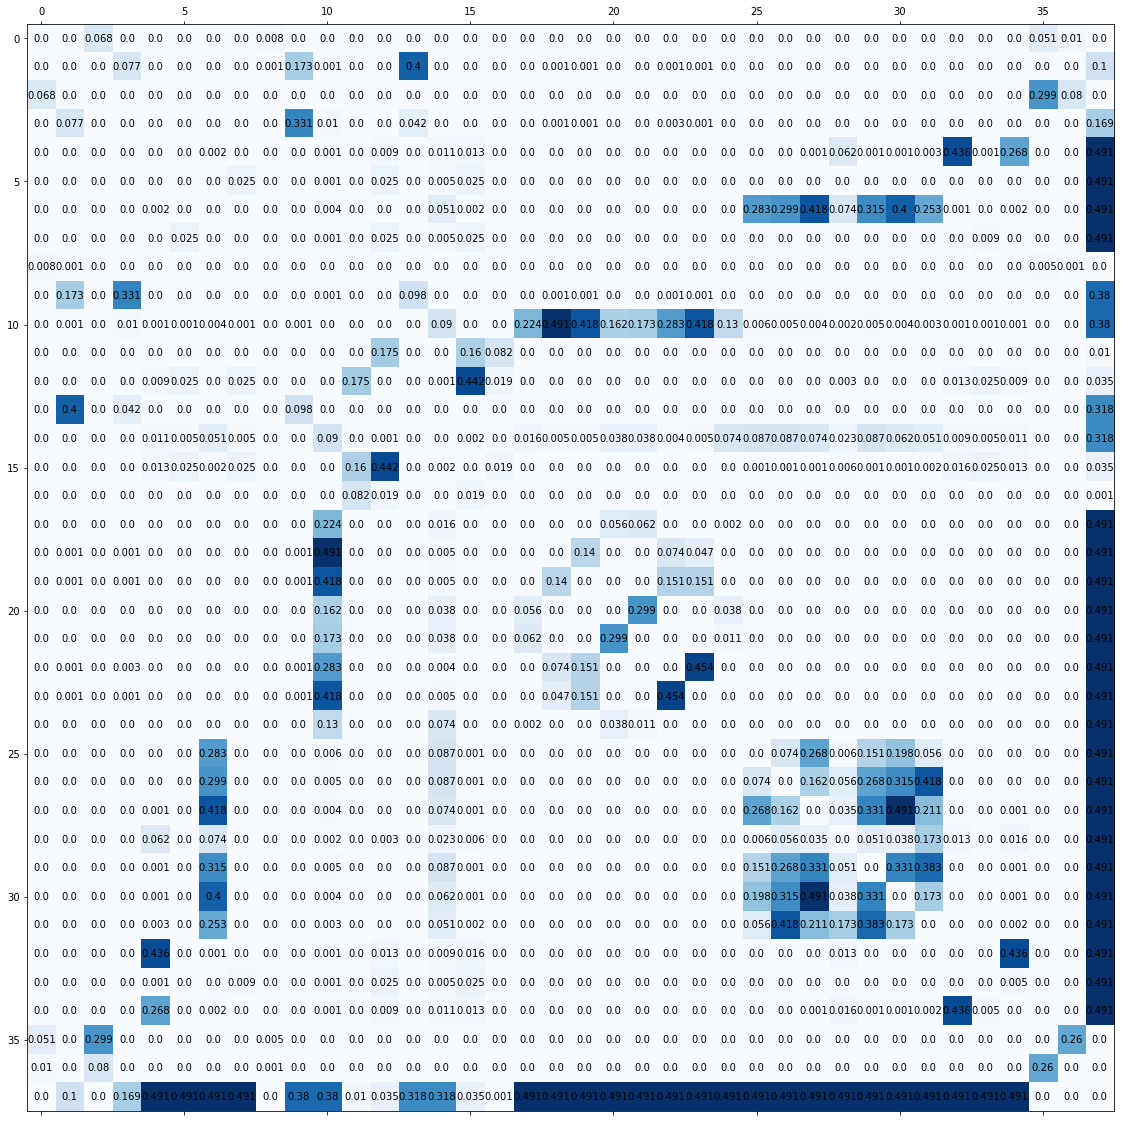

In [ ]:
#Display the similarities between features

elts= data2.columns
stats = np.zeros((data2.columns.shape[0],data2.columns.shape[0]))
p_values= np.zeros((data2.columns.shape[0],data2.columns.shape[0]))
for i,elti in enumerate(elts):
    for j,eltj in enumerate(elts):
        if list(data2[elti]) == list(data2[eltj]):
            pass
        else:      
            stat,p_value = scipy.stats.mannwhitneyu(np.array(data2[elti]), np.array(data2[eltj]), use_continuity=True, alternative=None)
            stats[i,j] = stat
            p_values[i,j] = p_value
        
fig, ax = plt.subplots(figsize = (20,20))
ax.matshow(p_values, cmap=plt.cm.Blues)

for i in range(p_values.shape[0]):
    for j in range(p_values.shape[1]):
        c = np.round(p_values[j,i],3)
        ax.text(i, j, str(c), va='center', ha='center')

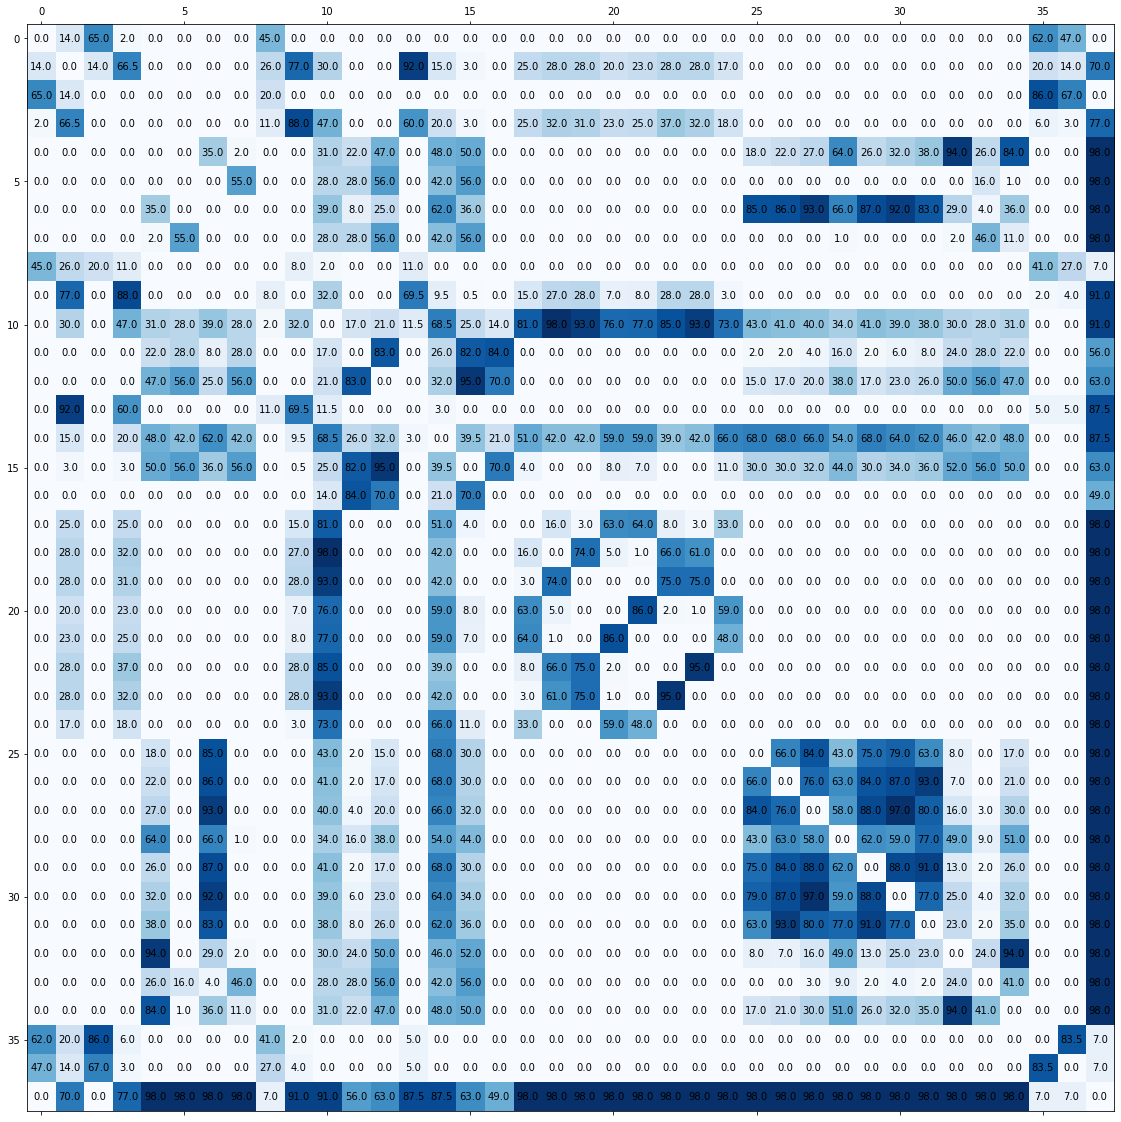

In [ ]:
fig, ax = plt.subplots(figsize = (20,20))
ax.matshow(stats, cmap=plt.cm.Blues)

for i in range(stats.shape[0]):
    for j in range(stats.shape[1]):
        c = np.round(stats[j,i],3)
        ax.text(i, j, str(c), va='center', ha='center')

###  Preparing the data and creating ML models 

##### SVM

In [ ]:
# List of imports
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


In [ ]:
#Extracting the label vectors
data = np.array(data2[elts[:-1]])
target = np.array(data2[elts[-1]])
# Splitting the data into training data and testing data
X_train, X_test, y_train, y_test = train_test_split(data,target,test_size=0.25, random_state=42,shuffle=True)
print("The training data shape is {} and the training target is {}".format(X_train.shape,y_train.shape))
print("The training data shape is {} and the training target is {}".format(X_test.shape,y_test.shape))

The training data shape is (10, 37) and the training target is (10,)
The training data shape is (4, 37) and the training target is (4,)


In [ ]:
# preparing a list of kernels to see what kernel for SVM has the best performance
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
perfo = np.zeros(len(kernels))

#Casting from float --> int
y_train=y_train.astype('int')
y_test=y_test.astype('int')

#Iterating over all the kernls and testing the performance.
for indice,name in enumerate(kernels):
    #Initialization of the SVM Classifier
    clf_svm=  svm.SVC(gamma=0.001,C=1, kernel= kernels[indice])
    #Training the Classifier
    clf_svm.fit(X_train, y_train)
    # Testing the performance of the classifier
    y_pred = clf_svm.predict(X_test)
    perfo[indice] = accuracy_score(y_test,y_pred)
    print("For SVM with kernel {} the accuracy is {}".format(name,perfo[indice]))
    
print("The best kernel is: ",kernels[np.argmax(perfo)])



# parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[1, 10]}
# svc = svm.SVC()
# clf = GridSearchCV(svc, parameters)
# clf.fit(X_train, y_train)
# print(clf.cv_results_['std_test_score'])
    

For SVM with kernel linear the accuracy is 1.0
For SVM with kernel poly the accuracy is 0.5
For SVM with kernel rbf the accuracy is 0.75
For SVM with kernel sigmoid the accuracy is 0.75
The best kernel is:  linear


#### SGD 

In [ ]:
#Initialization of SGD SVM Classifier
clf = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-3))
#Training the Classifier
clf.fit(X_train, y_train)
# Testing the performance of the classifier
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.75


#### Decision Tree

In [ ]:
#Initialization of the Decision Tree Classifier
clf_tree= DecisionTreeClassifier(criterion='gini', splitter='best')
#Training the Classifier
clf_tree.fit(X_train,y_train)
# Testing the performance of the classifier
clf_tree.score(X_test,y_test)
print(accuracy_score(y_test,y_pred))


0.75


# Random forest

In [ ]:
#Initialization of the Random Forest (a group of Decision Trees) Classifier
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
#Training the Classifier
clf_rf.fit(X_train, y_train)
# Testing the performance of the classifier
y_pred = clf_rf.predict(X_test)
print(accuracy_score(y_test,y_pred))

1.0


# KNN

In [ ]:
# Listing different number of neighbors to check the performance for different neighbors
neigh= np.linspace(1,10,10)
# Casting from float --> int
neigh = np.cast['i'](neigh)
for i in range(len(neigh)):
    #Initialization of the KNN Classifier
    clf_knn = KNeighborsClassifier(n_neighbors=neigh[i])
    #Training the Classifier
    clf_knn.fit(X_train, y_train)
    # Testing the performance of the classifier
    y_pred = clf_knn.predict(X_test)
    print(" For {} neighnors the accuracy is {} ".format(neigh[i],accuracy_score(y_test,y_pred)))

 For 1 neighnors the accuracy is 0.75 
 For 2 neighnors the accuracy is 0.5 
 For 3 neighnors the accuracy is 0.5 
 For 4 neighnors the accuracy is 0.5 
 For 5 neighnors the accuracy is 0.75 
 For 6 neighnors the accuracy is 0.5 
 For 7 neighnors the accuracy is 0.5 
 For 8 neighnors the accuracy is 0.5 
 For 9 neighnors the accuracy is 0.5 
 For 10 neighnors the accuracy is 0.5 


#### Naive Bayes

In [ ]:
#Initialization of the Naive Bayes Classifier
clf_NB = GaussianNB()
#Training the Classifier
clf_NB.fit(X_train, y_train)
# Testing the performance of the classifier
y_pred = clf_NB.predict(X_test)
print(accuracy_score(y_test,y_pred))


0.75


# Graphical analysis

### Gastric behavior 


In [ ]:
df = data2.copy()

def type_p(cl): 
    if cl == 1: 
        return 'pd'
    elif cl == 0:
        return 'healthy'


df['type'] = [type_p(class_p) for class_p in df['class']]
cols = ['percentage_normogastria_before',
        'percentage_bradygastria_before',
        'percentage_tachygastria_before',
        'percentage_other_before',
        'percentage_normogastria_After',
        'percentage_bradygastria_After',
        'percentage_tachygastria_After',
        'percentage_other_After',
        'type']
df_gb = df[cols] # df_gb displys columns with percentage of gastric behavior per patient before and after meal
df_gb.head()

,percentage_normogastria_before,percentage_bradygastria_before,percentage_tachygastria_before,percentage_other_before,percentage_normogastria_After,percentage_bradygastria_After,percentage_tachygastria_After,percentage_other_After,type
1,0.923077,0.038462,0.038462,0.000000,0.884615,0.115385,0.000000,0.0,healthy
2,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,pd
3,0.653846,0.269231,0.000000,0.076923,0.500000,0.500000,0.000000,0.0,healthy
4,0.884615,0.115385,0.000000,0.000000,0.423077,0.384615,0.192308,0.0,pd
5,0.923077,0.076923,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,healthy


In [ ]:
healthy_before = df_gb[df_gb['type'] == 'healthy'].iloc[:, :4]
healthy_after = df_gb[df_gb['type'] == 'healthy'].iloc[:, 4:]
pd_before = df_gb[df_gb['type'] == 'pd'].iloc[:, :4]
pd_after = df_gb[df_gb['type'] == 'pd'].iloc[:, 4:]

healthy_before

,percentage_normogastria_before,percentage_bradygastria_before,percentage_tachygastria_before,percentage_other_before
1,0.923077,0.038462,0.038462,0.000000
3,0.653846,0.269231,0.000000,0.076923
5,0.923077,0.076923,0.000000,0.000000
7,0.500000,0.423077,0.000000,0.038462
9,1.000000,0.000000,0.000000,0.000000
11,0.423077,0.576923,0.000000,0.000000
13,0.653846,0.346154,0.000000,0.000000


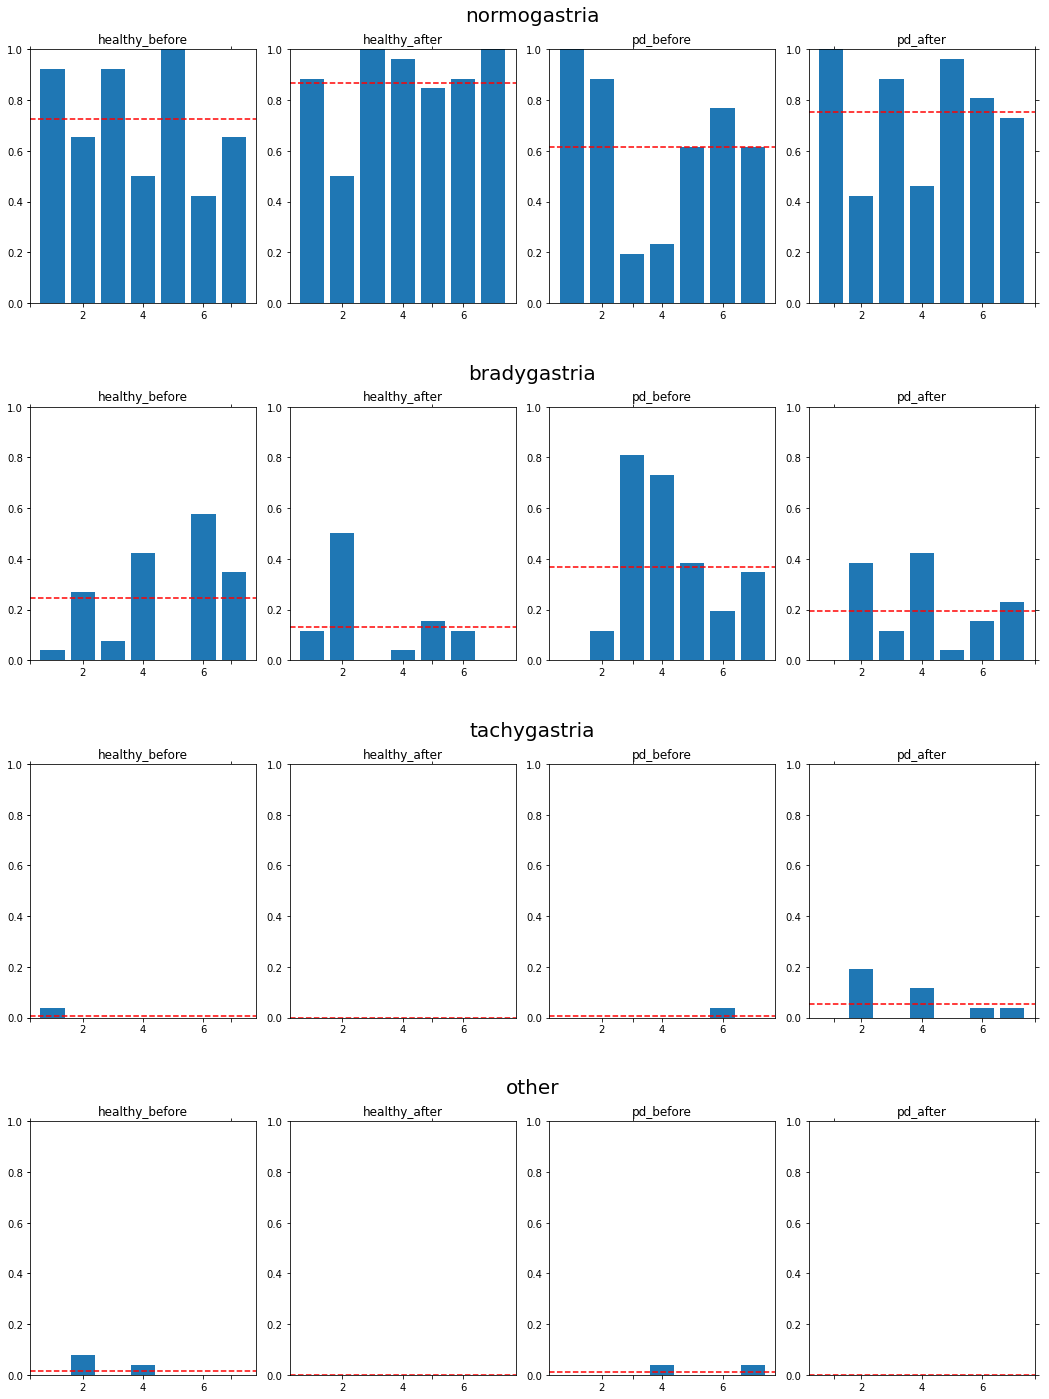

In [ ]:
# Compare gastric behavior

fig, big_axes = plt.subplots( figsize=(15.0, 20.0) , nrows=4, ncols=1, sharey=True) 

big_titles = ['normogastria',
             'bradygastria',
             'tachygastria',
             'other']
little_titles = ['healthy_before',
                'healthy_after',
                'pd_before',
                'pd_after']
patients = np.arange(1,8)

for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(big_titles[row-1] + '\n', fontsize=20)
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    big_ax._frameon = False


for row in range(1, len(big_titles) + 1):
    for plot in range(1,5):
        curr_plot = ((int(row) - 1) * 4) + int(plot) # Get current plot
        val = eval(little_titles[plot - 1]).iloc[:, row - 1] # Get values to plot
        mean = np.mean(val)
        ax = fig.add_subplot(4, 4, curr_plot)
        ax.axhline(y=mean, color='r', linestyle='--')
        ax.set_title(little_titles[plot-1])
        ax.bar(patients, height = val)
        ax.set_ylim([0.,1.])

fig.set_facecolor('w')
plt.tight_layout()
plt.show()

### Mean and std

In [ ]:
cols = ['type',
        'mean_power_1_before',
        'mean_power_2_before',
        'mean_power_3_before',
        'mean_power_4_before',
        'mean_power_1_after',
        'mean_power_2_after',
        'mean_power_3_after',
        'mean_power_4_after',
        'std_power_1_before',
        'std_power_2_before',
        'std_power_3_before',
        'std_power_4_before',
        'std_power_1_after',
        'std_power_2_after',
        'std_power_3_after',
        'std_power_4_after']
        
df_mstd = df[cols]
df_mstd = df_mstd.set_index('type')

In [ ]:
df_mstd.head()
after_cols = [col for col in df_mstd.columns if 'after' in col]
before_cols = [col for col in df_mstd.columns if 'before' in col]
healthy_before = df_mstd.loc['healthy', before_cols]
healthy_after = df_mstd.loc['healthy', after_cols]
pd_before = df_mstd.loc['pd', before_cols]
pd_after = df_mstd.loc['pd', after_cols]

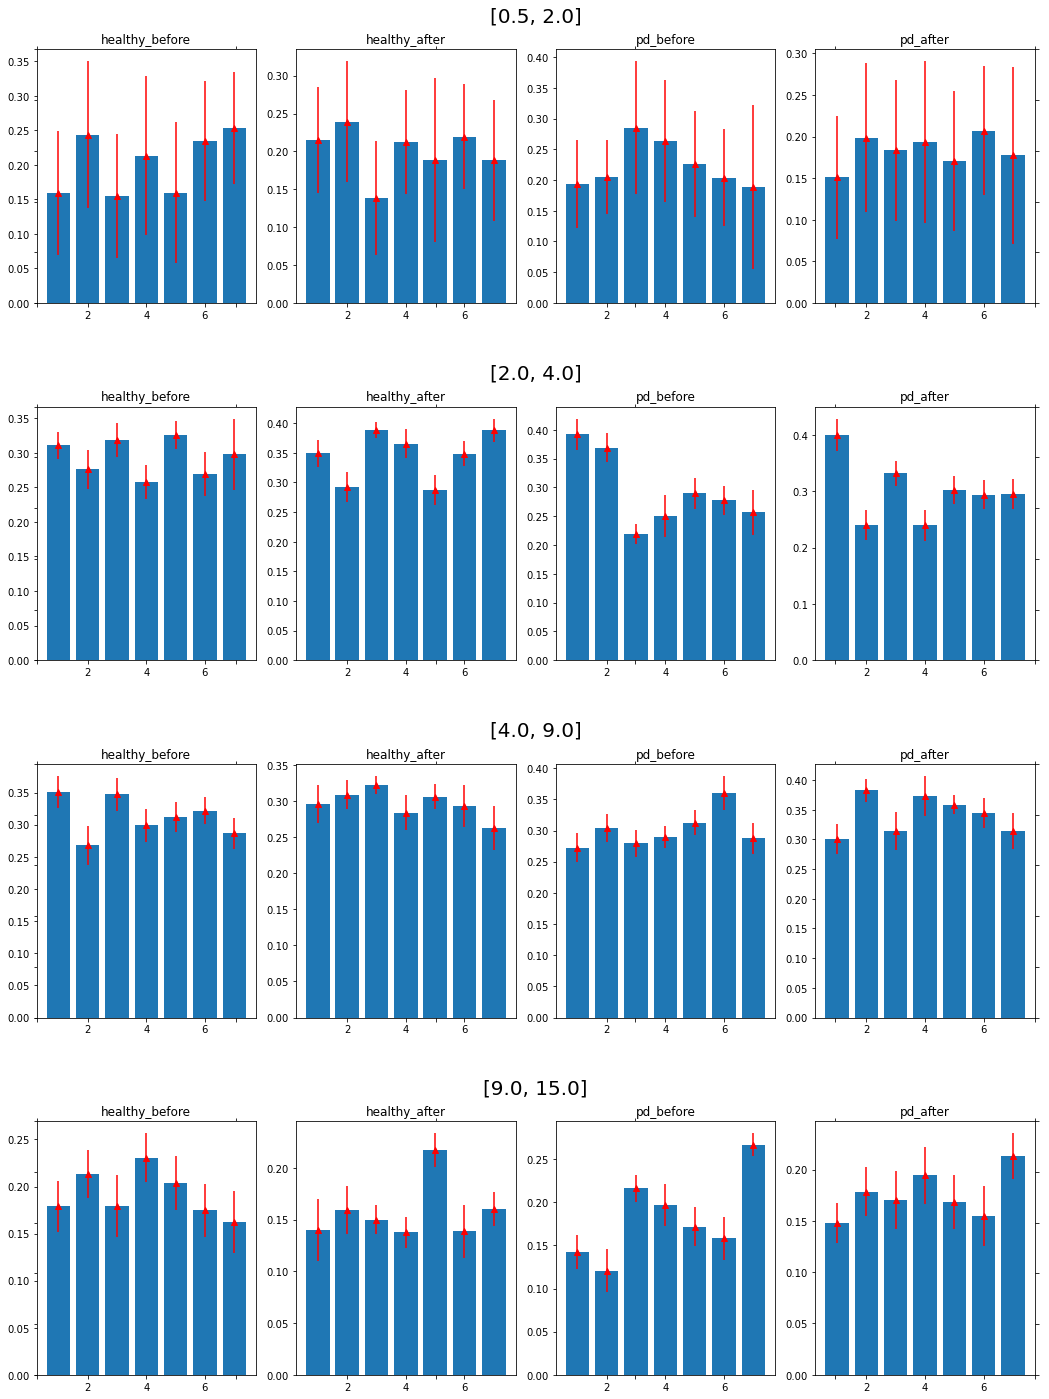

In [ ]:
# Compare mean and std

fig, big_axes = plt.subplots( figsize=(15.0, 20.0) , nrows=4, ncols=1, sharey=True) 

big_titles = ['[0.5, 2.0]',
             '[2.0, 4.0]',
             '[4.0, 9.0]',
             '[9.0, 15.0]']
little_titles = ['healthy_before',
                'healthy_after',
                'pd_before',
                'pd_after']
patients = np.arange(1,8)

for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(big_titles[row-1] + '\n', fontsize=20)
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    big_ax._frameon = False


for row in range(1, len(big_titles) + 1):
    for plot in range(1,5):
        curr_plot = ((int(row) - 1) * 4) + int(plot) # Get current plot
        val_mean = eval(little_titles[plot - 1]).iloc[:, row - 1] # Get mean values to plot
        val_std = eval(little_titles[plot - 1]).iloc[:, row - 1 + 3] # Get std values to plot
        val_std = val_std/2. # Because plot will be symmetrical 
        ax = fig.add_subplot(4, 4, curr_plot)
        ax.set_title(little_titles[plot-1])
        ax.bar(patients, height = val_mean)
        ax.errorbar(patients, val_mean, val_std.to_numpy(), linestyle='None', marker='^', color = 'r')
        
        #ax.set_ylim([0.,1.])

fig.set_facecolor('w')
plt.tight_layout()
plt.show()